In [402]:
#https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=vIWvJCpOVmwU
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
#from scipy.optimize import minimize
#from scipy import optimize
import pickle
#import statsmodels.api as sm
from math import ceil

In [403]:
hos_data = pickle.load( open( "new_hospitalized_data.p", "rb" ) )

In [404]:
hos_data_alhambra = hos_data[hos_data['geo_merge']=='Alhambra']

In [405]:
dates = [pd.to_datetime(i) - pd.to_datetime('2020-02-01')  for i in hos_data_alhambra['ep_date']]
dates = [i.days for i in dates]
dates = pd.Series(dates,index=hos_data_alhambra.index)
hos_data_alhambra['dates']=dates

C:\Users\suyan\AppData\Local\Temp/ipykernel_9900/2895224133.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hos_data_alhambra['dates']=dates


In [406]:
hos_data_alhambra = hos_data_alhambra.sort_values(by=['dates'])

In [407]:
import torch
from torch import nn, optim
from torch.autograd import Variable

# Preprocessing data

In [408]:
hos_data_alhambra

,Unnamed: 0,ep_date,geo_merge,hosp_14day,hosp_14day_rate,adj_hosp_14day_rate,hosp_rate_unstable,population,zip0,zip1,...,pop65,pop,med_income,mean_income,male,white,black,asian,hispanic,dates
242293,242294,3/1/2020,Alhambra,0,0,0,NaN,86724,91801.0,91803.0,...,15135.0,83057.0,123783.0,171425.0,40984.0,19360.0,1894.0,43022.0,84335.0,29
241962,241963,3/2/2020,Alhambra,0,0,0,NaN,86724,91801.0,91803.0,...,15135.0,83057.0,123783.0,171425.0,40984.0,19360.0,1894.0,43022.0,84335.0,30
241631,241632,3/3/2020,Alhambra,0,0,0,NaN,86724,91801.0,91803.0,...,15135.0,83057.0,123783.0,171425.0,40984.0,19360.0,1894.0,43022.0,84335.0,31
241300,241301,3/4/2020,Alhambra,0,0,0,NaN,86724,91801.0,91803.0,...,15135.0,83057.0,123783.0,171425.0,40984.0,19360.0,1894.0,43022.0,84335.0,32
240969,240970,3/5/2020,Alhambra,0,0,0,NaN,86724,91801.0,91803.0,...,15135.0,83057.0,123783.0,171425.0,40984.0,19360.0,1894.0,43022.0,84335.0,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,1326,2/27/2022,Alhambra,6,7,6,^,86724,91801.0,91803.0,...,15135.0,83057.0,123783.0,171425.0,40984.0,19360.0,1894.0,43022.0,84335.0,757
994,995,2/28/2022,Alhambra,5,6,5,^,86724,91801.0,91803.0,...,15135.0,83057.0,123783.0,171425.0,40984.0,19360.0,1894.0,43022.0,84335.0,758
663,664,3/1/2022,Alhambra,5,6,5,^,86724,91801.0,91803.0,...,15135.0,83057.0,123783.0,171425.0,40984.0,19360.0,1894.0,43022.0,84335.0,759
332,333,3/2/2022,Alhambra,3,3,3,^,86724,91801.0,91803.0,...,15135.0,83057.0,123783.0,171425.0,40984.0,19360.0,1894.0,43022.0,84335.0,760


In [409]:
daily_cases = hos_data_alhambra['hosp_14day'] 

test_data_size = 250
len_train = 30
forecast_len = 30 

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
train_data = np.expand_dims(train_data, axis=1)
test_data = np.expand_dims(test_data, axis=1)


In [410]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler = scaler.fit(train_data)

train_data = scaler.transform(train_data)

test_data = scaler.transform(test_data)

In [411]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [412]:
seq_length = len_train 

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [413]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        return out

In [414]:
num_epochs = 10000
learning_rate = 0.02

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.SmoothL1Loss(beta = 1)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
old_loss = 999999
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(X_train)
    optimizer.zero_grad()
    
    # obtain the loss function
    #print(outputs.shape)
    loss = criterion(outputs, y_train)
    #print(loss)
    #if loss<=15000:
    #    break
    old_loss = loss
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.04049
Epoch: 100, loss: 0.00040
Epoch: 200, loss: 0.00016
Epoch: 300, loss: 0.00015
Epoch: 400, loss: 0.00015
Epoch: 500, loss: 0.00015
Epoch: 600, loss: 0.00015
Epoch: 700, loss: 0.00015
Epoch: 800, loss: 0.00014
Epoch: 900, loss: 0.00014
Epoch: 1000, loss: 0.00014
Epoch: 1100, loss: 0.00014
Epoch: 1200, loss: 0.00014
Epoch: 1300, loss: 0.00015
Epoch: 1400, loss: 0.00014
Epoch: 1500, loss: 0.00014
Epoch: 1600, loss: 0.00014
Epoch: 1700, loss: 0.00014
Epoch: 1800, loss: 0.00014
Epoch: 1900, loss: 0.00014
Epoch: 2000, loss: 0.00014
Epoch: 2100, loss: 0.00013
Epoch: 2200, loss: 0.00013
Epoch: 2300, loss: 0.00014
Epoch: 2400, loss: 0.00013
Epoch: 2500, loss: 0.00013
Epoch: 2600, loss: 0.00013
Epoch: 2700, loss: 0.00013
Epoch: 2800, loss: 0.00013
Epoch: 2900, loss: 0.00013
Epoch: 3000, loss: 0.00014
Epoch: 3100, loss: 0.00013
Epoch: 3200, loss: 0.00013
Epoch: 3300, loss: 0.00014
Epoch: 3400, loss: 0.00014
Epoch: 3500, loss: 0.00013
Epoch: 3600, loss: 0.00013
Epoch: 3700, 

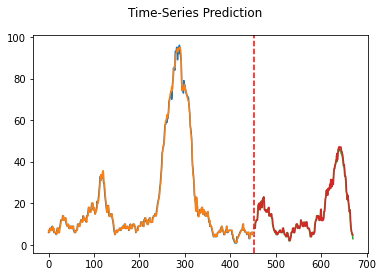

In [415]:
lstm.eval()
train_predict = lstm(X_train)

data_predict = train_predict.data.numpy()
dataY_plot = y_train.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=len(X_train), c='r', linestyle='--')

test_predict = lstm(X_test)
data_predict2 = test_predict.data.numpy()
dataY_plot2 = y_test.data.numpy()

data_predict2 = scaler.inverse_transform(data_predict2)
dataY_plot2 = scaler.inverse_transform(dataY_plot2)

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.plot(np.arange(len(dataY_plot2))+len(dataY_plot),dataY_plot2)
plt.plot(np.arange(len(dataY_plot2))+len(dataY_plot),data_predict2)
plt.suptitle('Time-Series Prediction')
plt.show()

In [416]:
def LSTM_pred(X,fc_len,train_len):
    input_ = X[0].reshape((1,train_len,1))
    preds = np.zeros((fc_len,1))
    for i in range(fc_len):
        preds[i,0] = lstm(input_.float())
        input_ = torch.cat((input_[0,1:len_train,0],torch.tensor(np.array([preds[i,0]])))).reshape((1,len_train,1))
    return preds
    

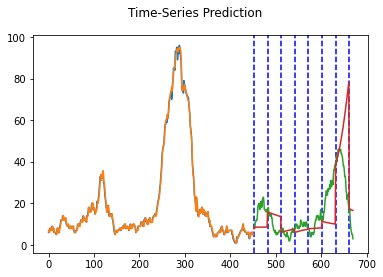

In [436]:
lstm.eval()
train_predict = lstm(X_train)



data_predict = train_predict.data.numpy()
dataY_plot = y_train.data.numpy()


data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=len(X_train), c='b', linestyle='--')
plt.axvline(x=len(X_train)+30, c='b', linestyle='--')
plt.axvline(x=len(X_train)+60, c='b', linestyle='--')
plt.axvline(x=len(X_train)+90, c='b', linestyle='--')
plt.axvline(x=len(X_train)+120, c='b', linestyle='--')
plt.axvline(x=len(X_train)+150, c='b', linestyle='--')
plt.axvline(x=len(X_train)+180, c='b', linestyle='--')
plt.axvline(x=len(X_train)+210, c='b', linestyle='--')

input_ = X_test[0].reshape((1,len_train,1))
preds = np.zeros((len(X_test),1))
for i in range(len(X_test)):
    if i%forecast_len == 0: # make monthly predictions. 
        input_ = X_test[i].reshape((1,len_train,1)) 
    preds[i,0] = lstm(input_.float())
    input_ = torch.cat((input_[0,1:len_train,0],torch.tensor(np.array([preds[i,0]])))).reshape((1,len_train,1))
#test_predict = lstm(X_test)
#data_predict2 = test_predict.data.numpy()
#dataY_plot2 = y_test.data.numpy()

data_predict3 = scaler.inverse_transform(preds)
dataY_plot3 = scaler.inverse_transform(dataY_plot2)

#dataY_plot4 = scaler.inverse_transform(y_y)

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.plot(np.arange(len(dataY_plot2))+len(dataY_plot),dataY_plot2)
plt.plot(np.arange(len(dataY_plot2))+len(dataY_plot),data_predict3)

plt.suptitle('Time-Series Prediction')
plt.show()

# Conformal Prediction - Exchangability Preserved Version

In [429]:
#Create testing sequence
y_true = y_train.data.numpy()
y_calb = np.zeros((len(y_true)-forecast_len,forecast_len))
for i in range(len(y_true)-forecast_len):
    y_calb[i] = y_true[i:i+forecast_len].reshape(forecast_len,)

In [430]:
def find(x,alpha,data_len,fclen):
    idx = ceil((data_len+1)*((1)-alpha))
    return np.sort(np.array(x))[idx-1]

In [456]:
def CFLSTM(X,fclen,train_len,alpha):
    for i in range(fclen): #initalize epsilon
        globals()['eps%s' % i] = [] 
    y_pred = np.zeros((len(X)-fclen,fclen))
    for i in range(len(X)-fclen):
        y_pred[i] = LSTM_pred(X[i].reshape((1,train_len,1)),fclen,train_len).reshape(fclen,)
        for j in range(fclen):
            globals()['eps%s' % j].append(abs(y_pred[i,j]-y_calb[i,j]))
    #print(eps0)
    #Bonferroni and finite sample correction
    output = np.zeros(fclen)
    for t in range(fclen):
        output[t] = find(globals()['eps%s' % t],alpha,len(y_pred)-fclen,fclen)
    return output
    


In [ ]:
epshtrain = CFLSTM(X_train,forecast_len,len_train,0.025)

In [ ]:
rps  = epshtrain.reshape((forecast_len,1))

In [ ]:
lstm.eval()
train_predict = lstm(X_train)



data_predict = train_predict.data.numpy()
dataY_plot = y_train.data.numpy()


data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

plt.axvline(x=len(X_train), c='b', linestyle='--')
plt.axvline(x=len(X_train)+30, c='b', linestyle='--')
plt.axvline(x=len(X_train)+60, c='b', linestyle='--')
plt.axvline(x=len(X_train)+90, c='b', linestyle='--')
plt.axvline(x=len(X_train)+120, c='b', linestyle='--')
plt.axvline(x=len(X_train)+150, c='b', linestyle='--')
plt.axvline(x=len(X_train)+180, c='b', linestyle='--')
plt.axvline(x=len(X_train)+210, c='b', linestyle='--')

input_ = X_test[0].reshape((1,len_train,1))
preds = np.zeros((len(X_test),1))
predsl = np.zeros((len(X_test),1))
predsu = np.zeros((len(X_test),1))
for i in range(len(X_test)):
    if i%forecast_len == 0: # make monthly predictions. 
        input_ = X_test[i].reshape((1,len_train,1)) 
    preds[i,0] = lstm(input_.float())
    predsl[i,0] = max(preds[i,0] - rps[i%forecast_len][0],0)
    predsu[i,0] = preds[i,0] + rps[i%forecast_len][0]
    input_ = torch.cat((input_[0,1:len_train,0],torch.tensor(np.array([preds[i,0]])))).reshape((1,len_train,1))
#test_predict = lstm(X_test)
#data_predict2 = test_predict.data.numpy()
#dataY_plot2 = y_test.data.numpy()

data_predict3 = scaler.inverse_transform(preds)
data_predict4 = scaler.inverse_transform(predsl)
data_predict5 = scaler.inverse_transform(predsu)
dataY_plot3 = scaler.inverse_transform(dataY_plot2)

#dataY_plot4 = scaler.inverse_transform(y_y)

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.plot(np.arange(len(dataY_plot2))+len(dataY_plot),dataY_plot2)
plt.plot(np.arange(len(dataY_plot2))+len(dataY_plot),data_predict3)
plt.plot(np.arange(len(dataY_plot2))+len(dataY_plot),data_predict4)
plt.plot(np.arange(len(dataY_plot2))+len(dataY_plot),data_predict5)

plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
scaler.inverse_transform(rps)

In [467]:
1%30

1